In [1]:
#Import des librairies
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import matplotlib as mp
import matplotlib.pyplot as plt

from pyspark.sql.functions import udf
from pyspark.sql.types import *
pd.set_option('display.max_columns', None)

In [2]:
#Les fichiers csv
pathVehicles = '/projet/datas/vehicles.csv'
pathCaracteristics = '/projet/datas/caracteristics.csv'
pathPlaces = '/projet/datas/places.csv'
pathUsers = '/projet/datas/users.csv'

dfVehicles = pd.read_csv(pathVehicles)
dfCaracteristics = pd.read_csv(pathCaracteristics, encoding="latin-1", low_memory=False)
dfPlaces = pd.read_csv(pathPlaces, low_memory=False)
dfUsers = pd.read_csv(pathUsers, sep=',')

In [3]:
#On garde uniquement le numéro d'accident et catégorie de véhicules
dfVehicles = dfVehicles[['Num_Acc', 'catv']]
dfVehicles

,Num_Acc,catv
0,201600000001,7
1,201600000001,2
2,201600000002,7
3,201600000003,7
4,201600000004,32
...,...,...
1433384,200500087952,7
1433385,200500087953,7
1433386,200500087953,2
1433387,200500087953,7


In [4]:
#On retire le lat, long, adr, com
dfCaracteristics = dfCaracteristics.drop(['lat', 'long', 'adr', 'com'], axis=1)

In [5]:
dfCaracteristics

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,gps,dep
0,201600000001,16,2,1,1445,1,2,1,8.0,3.0,M,590
1,201600000002,16,3,16,1800,1,2,6,1.0,6.0,M,590
2,201600000003,16,7,13,1900,1,1,1,1.0,6.0,M,590
3,201600000004,16,8,15,1930,2,2,1,7.0,3.0,M,590
4,201600000005,16,12,23,1100,1,2,3,1.0,3.0,M,590
...,...,...,...,...,...,...,...,...,...,...,...,...
839980,200500087950,5,12,21,2035,5,2,2,1.0,3.0,NaN,974
839981,200500087951,5,12,23,1010,1,2,1,1.0,3.0,NaN,974
839982,200500087952,5,12,26,1715,1,2,2,1.0,3.0,NaN,974
839983,200500087953,5,12,27,1500,1,2,3,2.0,5.0,NaN,974


In [6]:
# On en garde que 100000 (trop volumineux)
dfCaracteristics = dfCaracteristics.sample(100000)

In [7]:
# Modifie l'année pour qu'elle soit en 2006 et non 6
dfCaracteristics.an = dfCaracteristics.an + 2000

# Créer un date à partir de l'année, du mois et du jour
dfCaracteristics['date']= dfCaracteristics.apply(lambda row :
                          datetime.date(row.an,row.mois,row.jour), 
                          axis=1)
# On modifie en objet Date
dfCaracteristics['date'] = pd.to_datetime(dfCaracteristics['date'])

# Récupère le jour de la semaine numérique
dfCaracteristics['day_of_week'] = dfCaracteristics['date'].dt.dayofweek

# Récupère le numéro de jour de l'année
dfCaracteristics['day_of_year'] = dfCaracteristics['date'].dt.dayofyear
dfCaracteristics.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,gps,dep,date,day_of_week,day_of_year
181,201600000182,2016,12,29,1730,3,1,1,9.0,1.0,M,590,2016-12-29,3,364
595938,200700009823,2007,2,12,1745,1,2,3,2.0,3.0,NaN,750,2007-02-12,0,43
206635,201300028696,2013,4,17,925,1,2,1,1.0,6.0,NaN,540,2013-04-17,2,107
706594,200600036629,2006,6,15,110,5,2,1,2.0,6.0,NaN,930,2006-06-15,3,166
281028,201200044692,2012,9,6,2330,5,2,2,1.0,3.0,NaN,930,2012-09-06,3,250


In [8]:
# On supprime les colonnes qu'on n'a pas besoin
dfPlaces = dfPlaces.drop(['voie', 'v1', 'v2', 'nbv', 'pr', 'pr1', 'vosp', 'prof', 'lartpc', 'larrout'], axis=1)
dfPlaces

,Num_Acc,catr,circ,plan,surf,infra,situ,env1
0,201600000001,3.0,2.0,3.0,1.0,0.0,1.0,0.0
1,201600000002,3.0,1.0,2.0,1.0,0.0,1.0,0.0
2,201600000003,3.0,2.0,3.0,2.0,0.0,3.0,99.0
3,201600000004,4.0,2.0,1.0,1.0,0.0,1.0,99.0
4,201600000005,4.0,0.0,1.0,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...
839980,200500087950,4.0,2.0,1.0,1.0,0.0,1.0,3.0
839981,200500087951,4.0,2.0,2.0,1.0,0.0,1.0,0.0
839982,200500087952,4.0,1.0,1.0,1.0,0.0,1.0,3.0
839983,200500087953,4.0,2.0,1.0,1.0,0.0,1.0,0.0


In [9]:
# On supprime les colonnes qu'on n'a pas besoin
dfUsers = dfUsers.drop(['place', 'catu', 'trajet', 'secu', 'locp', 'actp', 'etatp'], axis=1)
dfUsers

,Num_Acc,grav,sexe,an_nais,num_veh
0,201600000001,1,2,1983.0,B02
1,201600000001,3,1,2001.0,A01
2,201600000002,3,1,1960.0,A01
3,201600000002,3,1,2000.0,A01
4,201600000002,3,2,1962.0,A01
...,...,...,...,...,...
1876000,200500087953,1,1,1972.0,B01
1876001,200500087953,1,1,1965.0,C01
1876002,200500087953,4,1,1990.0,A01
1876003,200500087954,4,1,1951.0,A01


In [10]:
# On merge les données pour avoir un seul dataframe
from functools import reduce
accidents = reduce(lambda left, right: pd.merge(left, right, on = "Num_Acc"), [dfVehicles, dfCaracteristics, dfPlaces, dfUsers])

In [11]:
pd.get_option("display.max_rows")
accidents

,Num_Acc,catv,an,mois,jour,hrmn,lum,agg,int,atm,col,gps,dep,date,day_of_week,day_of_year,catr,circ,plan,surf,infra,situ,env1,grav,sexe,an_nais,num_veh
0,201600000012,33,2016,1,28,1815,3,1,1,1.0,7.0,M,590,2016-01-28,3,28,3.0,2.0,1.0,1.0,0.0,0.0,0.0,3,1,1990.0,A01
1,201600000026,7,2016,12,6,1145,1,2,1,7.0,6.0,M,590,2016-12-06,1,341,4.0,2.0,1.0,1.0,6.0,1.0,3.0,1,2,1939.0,A01
2,201600000026,7,2016,12,6,1145,1,2,1,7.0,6.0,M,590,2016-12-06,1,341,4.0,2.0,1.0,1.0,6.0,1.0,3.0,3,2,2012.0,A01
3,201600000050,7,2016,9,8,1000,1,1,1,1.0,3.0,M,590,2016-09-08,3,252,3.0,2.0,1.0,1.0,1.0,1.0,99.0,1,1,1948.0,A01
4,201600000050,7,2016,9,8,1000,1,1,1,1.0,3.0,M,590,2016-09-08,3,252,3.0,2.0,1.0,1.0,1.0,1.0,99.0,4,1,1940.0,B02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424621,200500087929,7,2005,12,13,1450,1,1,2,1.0,3.0,NaN,974,2005-12-13,1,347,4.0,1.0,1.0,1.0,0.0,1.0,99.0,1,1,1980.0,A01
424622,200500087929,7,2005,12,13,1450,1,1,2,1.0,3.0,NaN,974,2005-12-13,1,347,4.0,1.0,1.0,1.0,0.0,1.0,99.0,4,2,1979.0,B01
424623,200500087941,7,2005,12,1,1125,1,2,1,1.0,6.0,NaN,974,2005-12-01,3,335,4.0,3.0,1.0,1.0,0.0,1.0,0.0,1,2,1965.0,A01
424624,200500087941,7,2005,12,1,1125,1,2,1,1.0,6.0,NaN,974,2005-12-01,3,335,4.0,3.0,1.0,1.0,0.0,1.0,0.0,4,1,2003.0,A01


In [12]:
type(accidents)

pandas.core.frame.DataFrame

In [13]:
# affiche le nombre d'accident
accidents.Num_Acc.count()

424626

**D'après nos données, nous avons 42726 accidents recensés entre 2005 et 2016**

In [14]:
# affiche le nombre d'accident par sexe
accidents.groupby('sexe').Num_Acc.count()

sexe
1    285026
2    139600
Name: Num_Acc, dtype: int64

In [15]:
# accidents = accidents.sample(10000)

*sexe: 1 - Homme 2 - Femme* 

**Sur la période de 2005 à 2016, les hommes ont causé plus de deux fois plus d'accidents que les femmes sur les 41303 recensés**

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


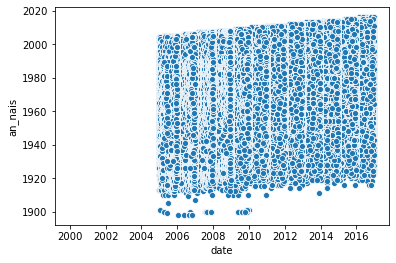

In [16]:
# affichage des données dans un graph, on peu voir que l'année de naissance des personnes par date d'accident
sb.scatterplot(x="date", y="an_nais", data=accidents)

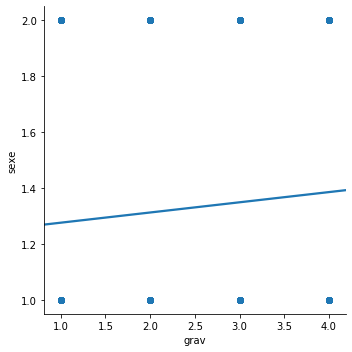

In [17]:
sb.lmplot(x="grav", y="sexe", data=accidents)

In [18]:
accidents.corr()

,Num_Acc,catv,an,mois,jour,hrmn,lum,agg,int,atm,col,dep,day_of_week,day_of_year,catr,circ,plan,surf,infra,situ,env1,grav,sexe,an_nais
Num_Acc,1.000000,0.093763,1.000000,-0.019614,-0.012690,-0.000553,-0.005817,-0.010815,0.019716,-0.043161,-0.000807,0.044263,-0.026384,-0.019603,-0.010227,-0.043646,-0.024333,-0.017374,-0.013601,-0.013021,0.168509,-0.002303,-0.016379,0.151134
catv,0.093763,1.000000,0.093762,0.001431,-0.000521,0.012082,-0.017181,0.039985,0.026630,-0.030749,-0.002286,0.029433,-0.026355,0.001353,0.031663,-0.030632,0.001416,-0.014401,0.004241,-0.021782,0.015877,0.003342,-0.074802,0.025527
an,1.000000,0.093762,1.000000,-0.019644,-0.012691,-0.000552,-0.005821,-0.010819,0.019715,-0.043161,-0.000810,0.044244,-0.026385,-0.019633,-0.010224,-0.043645,-0.024328,-0.017372,-0.013599,-0.013019,0.168508,-0.002303,-0.016378,0.151132
mois,-0.019614,0.001431,-0.019644,1.000000,0.012093,-0.007030,0.045609,-0.034175,-0.010825,0.031265,0.010747,-0.013731,0.024046,0.996459,-0.032773,0.025097,-0.008069,-0.021271,-0.012778,-0.004603,-0.000435,0.001110,0.001985,0.006071
jour,-0.012690,-0.000521,-0.012691,0.012093,1.000000,0.006940,-0.011022,-0.010897,0.000451,-0.002523,0.001498,-0.005560,0.012385,0.095832,-0.009973,0.005143,-0.002548,-0.011502,-0.002245,-0.005190,-0.007668,0.003925,0.002451,-0.000699
hrmn,-0.000553,0.012082,-0.000552,-0.007030,0.006940,1.000000,0.100743,0.060896,0.019526,-0.062147,-0.048253,0.010633,-0.025387,-0.006520,0.066618,-0.036927,-0.014413,-0.044550,0.006422,-0.035998,0.005907,-0.016327,0.013903,0.017369
lum,-0.005817,-0.017181,-0.005821,0.045609,-0.011022,0.100743,1.000000,0.104116,0.032198,0.014248,0.031710,0.051033,0.098279,0.045432,0.036248,-0.016085,-0.016127,0.052503,0.018025,0.017966,0.004806,0.024515,-0.050851,0.114776
agg,-0.010815,0.039985,-0.010819,-0.034175,-0.010897,0.060896,0.104116,1.000000,0.186456,-0.114076,0.021848,0.069063,-0.072285,-0.035012,0.548951,-0.213321,-0.187025,-0.104451,0.019012,-0.060078,-0.018101,0.024935,-0.007195,0.031912
int,0.019716,0.026630,0.019715,-0.010825,0.000451,0.019526,0.032198,0.186456,1.000000,-0.015361,-0.045425,0.031784,-0.018476,-0.010709,0.137932,-0.103690,-0.038976,-0.032869,0.192298,-0.054989,0.013795,0.005012,-0.002083,-0.005654
atm,-0.043161,-0.030749,-0.043161,0.031265,-0.002523,-0.062147,0.014248,-0.114076,-0.015361,1.000000,0.026783,-0.014814,0.014875,0.031521,-0.091998,0.065023,0.041451,0.298691,-0.000679,0.012922,-0.013368,-0.010279,0.022463,-0.016767


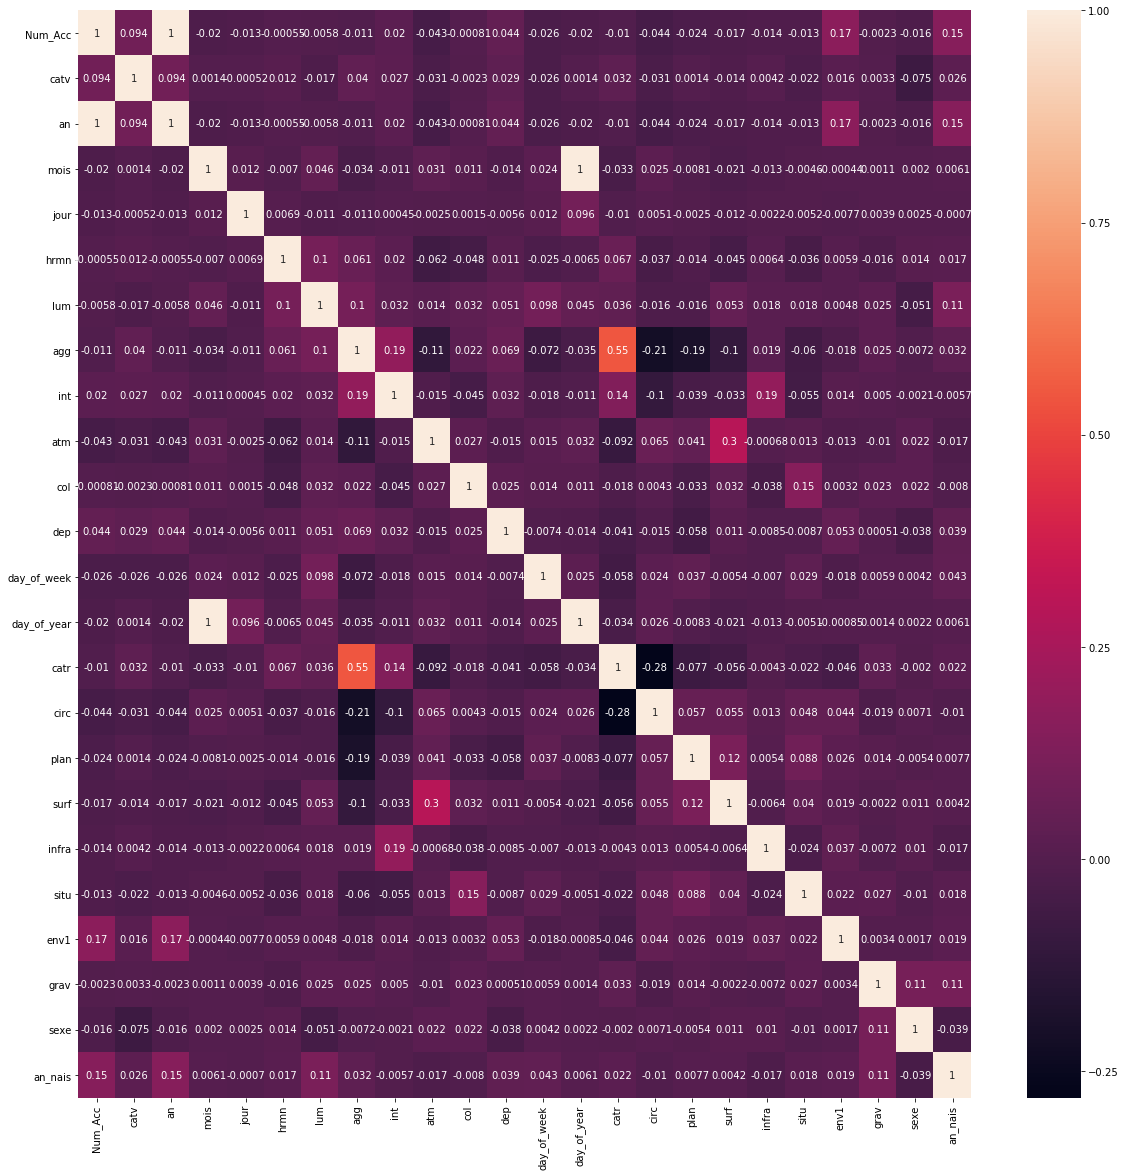

In [19]:
mp.pyplot.subplots(figsize=(20,20))
heatmap = sb.heatmap(accidents.corr(), annot=True)

**Via la matrice de corrélation, nous pouvons remarquer que les accidents sont plus grave selon année de naissance et le sexe de la personne concernée.**

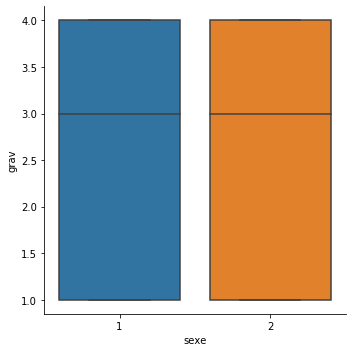

In [20]:
sb.catplot(x="sexe", y="grav", data=accidents, kind="box")

**On s'apperçois que l'on as aucune valeur abérantes pour les valeurs graves (valeur extérieur a 1, 2, 3 ou 4)**

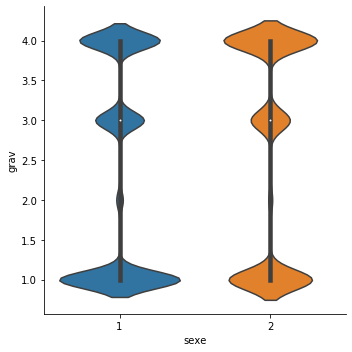

In [21]:
sb.catplot(x="sexe", y="grav", data=accidents, kind="violin")

*4 - Blessure légère*

*3 - Blessés hospitalisés*

*2 - Tué*

*1 - Indemne*

**Ici on peu constater que les hommes dans beaucoup accidents sont indemne et que les femmes on plus tendances à ce blesser
Nous pouvons remarquer les hommes ont tendance à se blesser moins gravement que les femmes lors des accidents.**

Text(0, 0.5, "Nombre d'accidents")

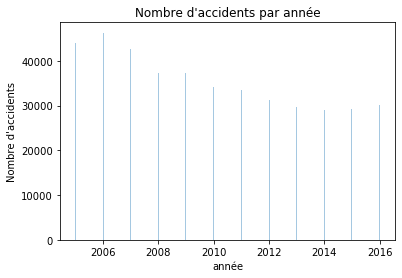

In [22]:
sb.distplot(accidents.an,bins=365,kde=False)
plt.title('Nombre d\'accidents par année')
plt.xlabel('année')
plt.ylabel('Nombre d\'accidents')

**On peut constater que le nombre d'accidents à tendance à diminuer avec le temps**

Text(0, 0.5, "Nombre d'accidents")

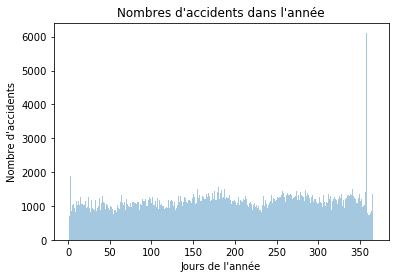

In [23]:
sb.distplot(accidents.day_of_year,bins=365,kde=False);
plt.title('Nombres d\'accidents dans l\'année')
plt.xlabel('Jours de l\'année')
plt.ylabel('Nombre d\'accidents')

**On peut remarqué que durant l'année le plus haut pic est presque à la fin, 25 décembre ?**

Text(0, 0.5, "Nombre d'accidents")

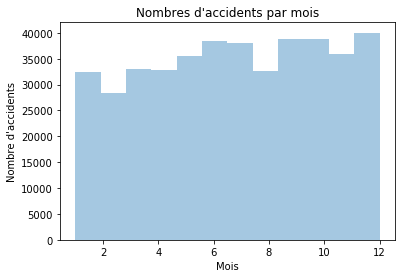

In [24]:
sb.distplot(accidents.mois,bins=12,kde=False);
plt.title('Nombres d\'accidents par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'accidents')

**Le nombres d'accidents est plus grand en septembre, octobre et décembre**

Text(0, 0.5, "Nombre d'accident")

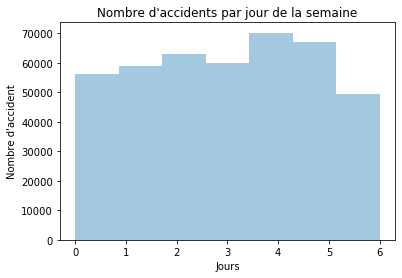

In [25]:
sb.distplot(accidents.day_of_week,bins=7,kde=False);
plt.title('Nombre d\'accidents par jour de la semaine')
plt.xlabel('Jours')
plt.ylabel('Nombre d\'accident')

**Le nombre d'accidents est le plus grand le vendredi et beaucoup moins le dimanche**

Text(0, 0.5, "Nombre d'accident")

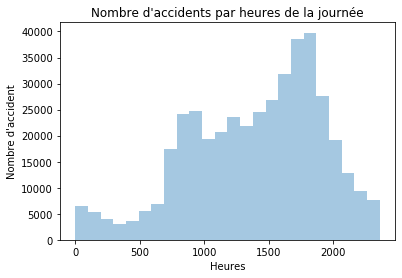

In [26]:
sb.distplot(accidents.hrmn,bins=24,kde=False);
plt.title('Nombre d\'accidents par heures de la journée')
plt.xlabel('Heures')
plt.ylabel('Nombre d\'accident')

**On s'apperçois que le nombre d'accidents est plus élévé entre 15h et 20h**

In [27]:

morts = accidents[accidents['catr'] == 2]
morts

,Num_Acc,catv,an,mois,jour,hrmn,lum,agg,int,atm,col,gps,dep,date,day_of_week,day_of_year,catr,circ,plan,surf,infra,situ,env1,grav,sexe,an_nais,num_veh
154,201600000402,17,2016,11,7,1600,1,1,1,1.0,5.0,M,20,2016-11-07,0,312,2.0,2.0,1.0,1.0,0.0,1.0,99.0,1,1,1990.0,B02
155,201600000402,17,2016,11,7,1600,1,1,1,1.0,5.0,M,20,2016-11-07,0,312,2.0,2.0,1.0,1.0,0.0,1.0,99.0,4,2,1975.0,A01
156,201600000402,17,2016,11,7,1600,1,1,1,1.0,5.0,M,20,2016-11-07,0,312,2.0,2.0,1.0,1.0,0.0,1.0,99.0,4,2,1982.0,A01
157,201600000402,17,2016,11,7,1600,1,1,1,1.0,5.0,M,20,2016-11-07,0,312,2.0,2.0,1.0,1.0,0.0,1.0,99.0,3,2,1974.0,A01
158,201600000402,17,2016,11,7,1600,1,1,1,1.0,5.0,M,20,2016-11-07,0,312,2.0,2.0,1.0,1.0,0.0,1.0,99.0,1,1,1970.0,C03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424584,200500087852,99,2005,12,17,755,1,1,1,1.0,2.0,NaN,972,2005-12-17,5,351,2.0,2.0,1.0,1.0,0.0,1.0,99.0,4,1,1959.0,B01
424595,200500087900,2,2005,12,9,1226,1,1,1,1.0,2.0,NaN,973,2005-12-09,4,343,2.0,1.0,4.0,1.0,5.0,1.0,0.0,1,1,1961.0,A01
424596,200500087900,2,2005,12,9,1226,1,1,1,1.0,2.0,NaN,973,2005-12-09,4,343,2.0,1.0,4.0,1.0,5.0,1.0,0.0,4,1,1951.0,B01
424597,200500087900,7,2005,12,9,1226,1,1,1,1.0,2.0,NaN,973,2005-12-09,4,343,2.0,1.0,4.0,1.0,5.0,1.0,0.0,1,1,1961.0,A01


Text(0, 0.5, 'Nombre de tués')

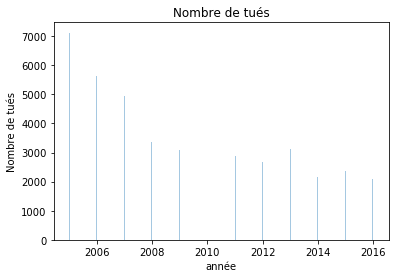

In [28]:
sb.distplot(morts.an,bins=365,kde=False)
plt.title('Nombre de tués')
plt.xlabel('année')
plt.ylabel('Nombre de tués')

**Comme pour les accidents, le nombres duminue au fil des années**

Text(0, 0.5, 'Nombre de tués')

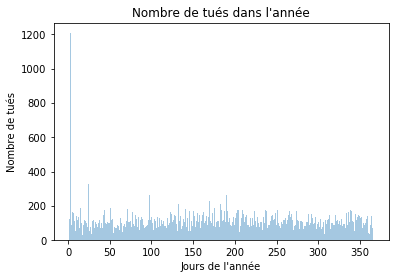

In [29]:
sb.distplot(morts.day_of_year,bins=365,kde=False);
plt.title('Nombre de tués dans l\'année')
plt.xlabel('Jours de l\'année')
plt.ylabel('Nombre de tués')

**On peut voir des journées avec un grand nombre de tués, surtout début janvier**

Text(0, 0.5, 'Nombre de tués')

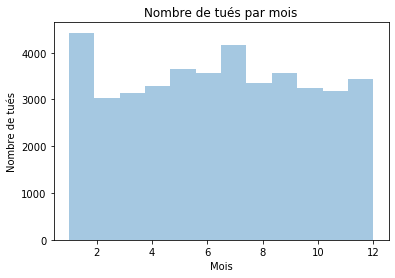

In [30]:
sb.distplot(morts.mois,bins=12,kde=False);
plt.title('Nombre de tués par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de tués')

**On peut voir que le nombre de tué est plus haut le mois numéro 1 donc le mois de Janvier**

A consommé avec modération non ? ¯\\_(ツ)_/¯

Text(0, 0.5, 'Nombre de tués')

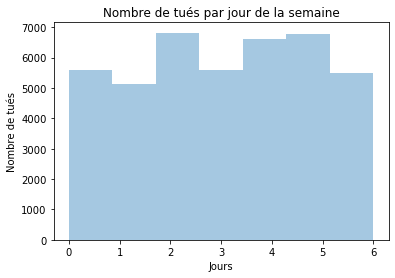

In [31]:
sb.distplot(morts.day_of_week,bins=7,kde=False);
plt.title('Nombre de tués par jour de la semaine')
plt.xlabel('Jours')
plt.ylabel('Nombre de tués')

**On peut voir que le nombre de tué est plus fort le vendredi, samedi et mercredi**

Text(0, 0.5, 'Nombre de tués')

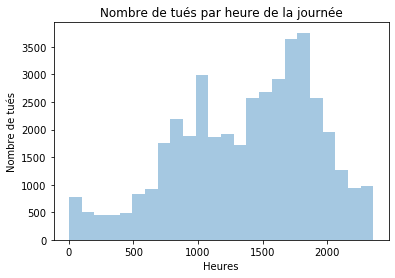

In [32]:
sb.distplot(morts.hrmn,bins=24,kde=False);
plt.title('Nombre de tués par heure de la journée')
plt.xlabel('Heures')
plt.ylabel('Nombre de tués')

**On peut voir que le nombre de tué est plus haut entre 15h et 20h, ce qui colle avec le nombre d'accidents**